In [ ]:
%pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# remove background from the image
%pip install rembg


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from rembg import remove 
from PIL import Image 

input_path="image.png"
output_path= "output.png"

inp= Image.open(input_path)
output= remove(inp)
output.save(output_path)



Edge density in shadow: 0.2532
Detected Hard Shadow
Estimated light direction (2D projection): (-10, 30)


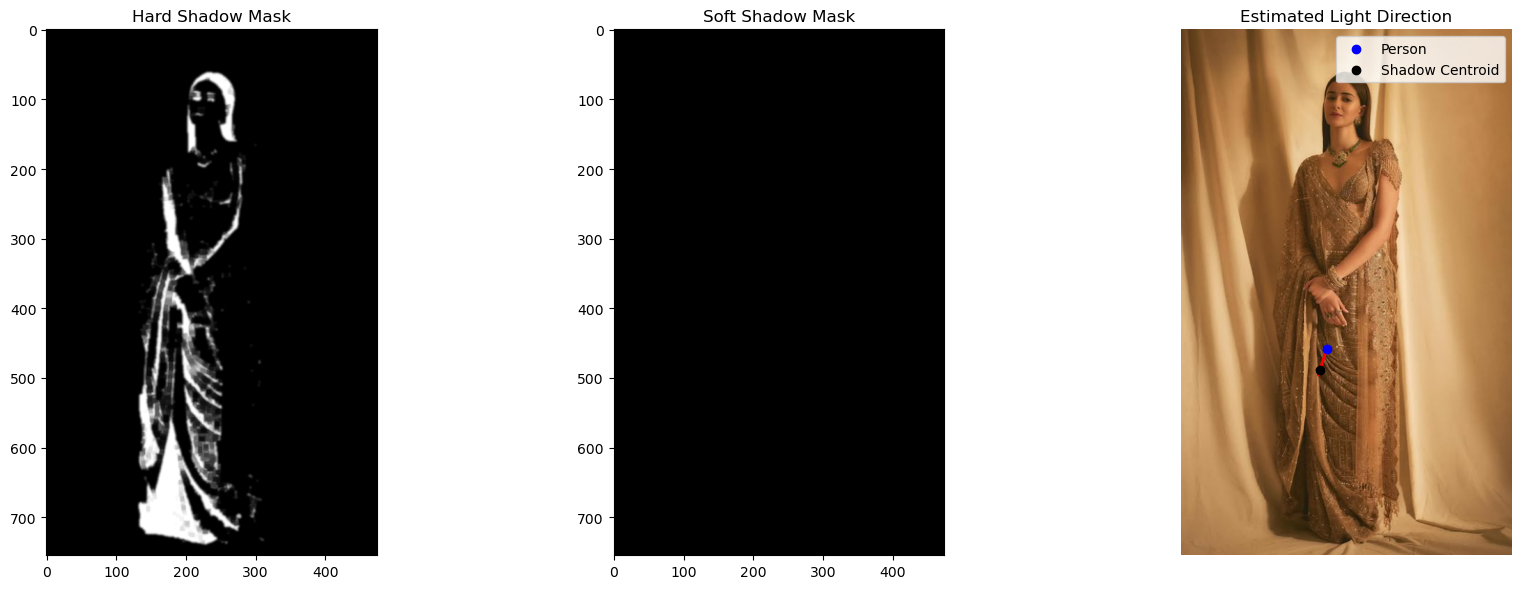

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('image.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Detect shadow region
_, shadow_mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
shadow_mask = cv2.GaussianBlur(shadow_mask, (7, 7), 0)
shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

# Step 2: Shadow Classification
edges = cv2.Canny(gray, 30, 100)
shadow_edges = cv2.bitwise_and(edges, shadow_mask)
shadow_area = np.count_nonzero(shadow_mask)
edge_area = np.count_nonzero(shadow_edges)
edge_density = edge_area / (shadow_area + 1e-5)

print(f"Edge density in shadow: {edge_density:.4f}")

if edge_density > 0.05:
    print("Detected Hard Shadow")
    hard_shadow_mask = shadow_mask.copy()
    soft_shadow_mask = np.zeros_like(shadow_mask)
else:
    print("Detected Soft Shadow")
    soft_shadow_mask = shadow_mask.copy()
    hard_shadow_mask = np.zeros_like(shadow_mask)

# Step 3: Estimate light direction
contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    person_point = (x + w // 2, y + h // 2)
    shadow_centroid = cv2.moments(largest_contour)

    if shadow_centroid["m00"] != 0:
        cx = int(shadow_centroid["m10"] / shadow_centroid["m00"])
        cy = int(shadow_centroid["m01"] / shadow_centroid["m00"])
        shadow_point = (cx, cy)

        direction_vector = (shadow_point[0] - person_point[0], shadow_point[1] - person_point[1])
        print(f"Estimated light direction (2D projection): {direction_vector}")

        # Visualization
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(hard_shadow_mask, cmap='gray')
        plt.title("Hard Shadow Mask")

        plt.subplot(1, 3, 2)
        plt.imshow(soft_shadow_mask, cmap='gray')
        plt.title("Soft Shadow Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb)
        plt.arrow(person_point[0], person_point[1], direction_vector[0], direction_vector[1],
                  color='red', width=2)
        plt.scatter(*person_point, color='blue', label='Person')
        plt.scatter(*shadow_point, color='black', label='Shadow Centroid')
        plt.legend()
        plt.title("Estimated Light Direction")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Shadow centroid calculation failed.")
else:
    print("No shadow detected.")

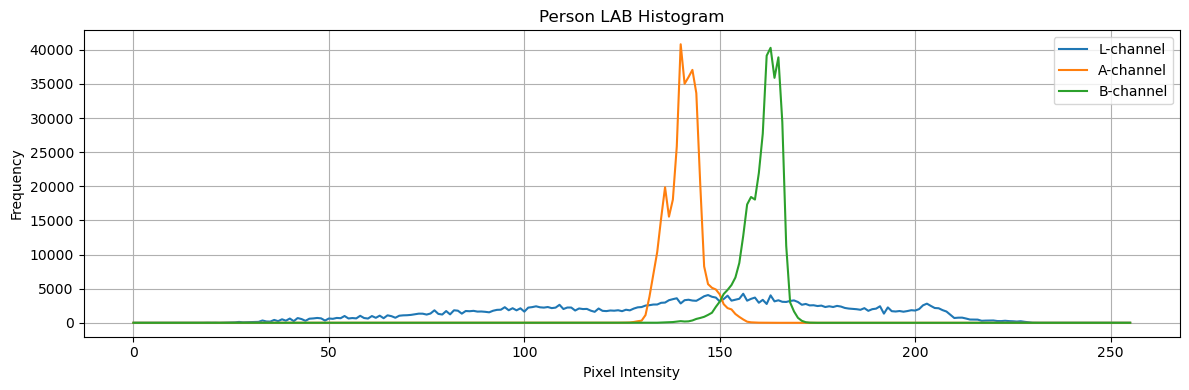

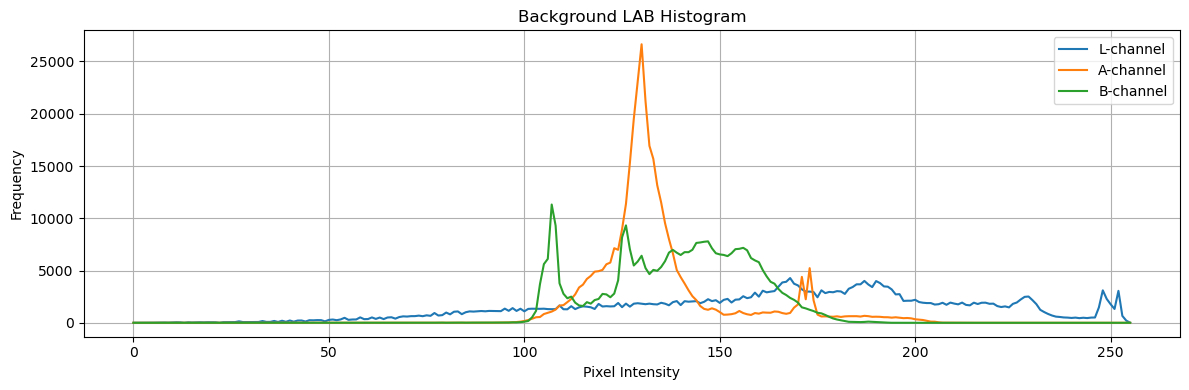

Histogram Similarity (Correlation for L, A, B): [0.6669994451805542, 0.22461596695631952, 0.3133571383004676]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the images
person = cv2.imread('image.png')
background = cv2.imread('bg.png')


background_resized = cv2.resize(background, (person.shape[1], person.shape[0]))


person_lab = cv2.cvtColor(person, cv2.COLOR_BGR2LAB)
background_lab = cv2.cvtColor(background_resized, cv2.COLOR_BGR2LAB)


def calculate_histogram(image, title):
    colors = ('L', 'A', 'B')
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, label=f'{col}-channel')
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


calculate_histogram(person_lab, 'Person LAB Histogram')
calculate_histogram(background_lab, 'Background LAB Histogram')


similarity = []
for i in range(3):  # L, A, B channels
    h1 = cv2.calcHist([person_lab], [i], None, [256], [0, 256])
    h2 = cv2.calcHist([background_lab], [i], None, [256], [0, 256])
    similarity.append(cv2.compareHist(h1, h2, cv2.HISTCMP_CORREL))

print("Histogram Similarity (Correlation for L, A, B):", similarity)

In [ ]:
import cv2
import numpy as np

# Load images
background = cv2.imread("background.jpg")
person = cv2.imread("output.png", cv2.IMREAD_UNCHANGED)  
# Split channels
b, g, r, alpha = cv2.split(person)
person_rgb = cv2.merge((b, g, r))
mask = alpha


x_offset = 800
bottom_margin = 50


max_height = background.shape[0] - bottom_margin
max_width = background.shape[1] - x_offset

# Auto scale if person doesn't fit
scale_h = max_height / person_rgb.shape[0]
scale_w = max_width / person_rgb.shape[1]
scale = min(0.9, scale_h, scale_w)

# Resize person and mask
new_size = (int(person_rgb.shape[1] * scale), int(person_rgb.shape[0] * scale))
person_rgb = cv2.resize(person_rgb, new_size)
mask = cv2.resize(mask, new_size)

# Calculate placement again
y_offset = background.shape[0] - person_rgb.shape[0] - bottom_margin


roi = background[y_offset:y_offset + person_rgb.shape[0], x_offset:x_offset + person_rgb.shape[1]]

# mask
mask_3ch = cv2.merge([mask, mask, mask]) / 255.0

# Blend
roi = roi.astype(np.float32)
person_rgb = person_rgb.astype(np.float32)
mask_3ch = mask_3ch.astype(np.float32)

blended = roi * (1 - mask_3ch) + person_rgb * mask_3ch
blended = blended.astype(np.uint8)

# Composite
final = background.copy()
final[y_offset:y_offset + blended.shape[0], x_offset:x_offset + blended.shape[1]] = blended

#Soft Shadow
shadow = cv2.GaussianBlur(mask, (45, 45), sigmaX=30)
shadow = (shadow / 255.0 * 90).astype(np.uint8)
shadow_layer = np.zeros_like(background)
shadow_color = cv2.merge([shadow, shadow, shadow])

shadow_x = x_offset + 30
shadow_y = y_offset + 20

# Crop if shadow goes out of bounds
sh_h, sh_w = shadow.shape
sh_h = min(sh_h, background.shape[0] - shadow_y)
sh_w = min(sh_w, background.shape[1] - shadow_x)
shadow_color = shadow_color[:sh_h, :sh_w]
shadow_region = shadow_layer[shadow_y:shadow_y + sh_h, shadow_x:shadow_x + sh_w]

# Overlay shadow
np.copyto(shadow_region, shadow_color, where=shadow_color > 0)

# Subtract to simulate shadow
final = cv2.subtract(final, shadow_layer)

# Save
cv2.imwrite("final_composite.png", final)
print("✅ Composite saved as final_composite.png")


✅ Composite saved as final_composite.png
